In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
import folium

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import matplotlib as mpl
from sklearn.cluster import KMeans



In [2]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_of_Barcelona").text

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')



In [3]:
neighborhoodList = []
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)
    

In [4]:
barca_df = pd.DataFrame({"Neighborhood": neighborhoodList})

barca_df

,Neighborhood
0,L'Antiga Esquerra de l'Eixample
1,El Baix Guinardó
2,"La Barceloneta, Barcelona"
3,Baró de Viver
4,El Besòs i el Maresme
...,...
71,Verdum
72,La Verneda i la Pau
73,Vila de Gràcia
74,La Vila Olímpica del Poblenou


In [5]:
barca_df.shape

(76, 1)

In [6]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Barcelona,Spain'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [7]:
coords = [ get_latlng(neighborhood) for neighborhood in barca_df["Neighborhood"].tolist() ]

In [8]:
(coords)

[[41.39069000000006, 2.1449400000000196],
 [41.410219500000004, 2.168793000000016],
 [41.38185000000004, 2.1915100000000507],
 [41.44804000000005, 2.19963000000007],
 [41.416660000000036, 2.21392000000003],
 [41.436360000000036, 2.2032500000000255],
 [41.369860000000074, 2.136220000000037],
 [41.40859000000006, 2.163820000000044],
 [41.41068000000007, 2.1806300000000647],
 [41.41665000000006, 2.1625300000000607],
 [41.43508000000003, 2.166530000000023],
 [41.28669000000008, 1.7239000000000715],
 [41.42352000000005, 2.151740000000075],
 [41.46037000000007, 2.177220000000034],
 [41.40912000000003, 2.1920800000000327],
 [41.42912000000007, 2.152680000000032],
 [41.41818000000006, 2.1478000000000748],
 [41.42492000000004, 2.181470000000047],
 [41.38695000000007, 2.1363100000000372],
 [41.402380047752295, 2.2085899961049],
 [41.39498000000003, 2.1674800000000687],
 [41.42548000000005, 2.1664100000000417],
 [41.37131000000005, 2.1464500000000726],
 [41.39519000000007, 2.1830700000000434],
 [

In [9]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [10]:
barca_df['Latitude']=df_coords['Latitude']
barca_df['Longitude']=df_coords['Longitude']

In [11]:
barca_df

,Neighborhood,Latitude,Longitude
0,L'Antiga Esquerra de l'Eixample,41.39069,2.144940
1,El Baix Guinardó,41.41022,2.168793
2,"La Barceloneta, Barcelona",41.38185,2.191510
3,Baró de Viver,41.44804,2.199630
4,El Besòs i el Maresme,41.41666,2.213920
...,...,...,...
71,Verdum,41.44281,2.175310
72,La Verneda i la Pau,41.42332,2.205130
73,Vila de Gràcia,41.40445,2.155050
74,La Vila Olímpica del Poblenou,41.39125,2.191640


In [12]:
address = 'Barcelona,Spain'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Barcelona,Spain {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Barcelona,Spain 41.3828939, 2.1774322.


In [13]:
map_barca = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(barca_df['Latitude'], barca_df['Longitude'], barca_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#22fc11',
        fill_opacity=0.8).add_to(map_barca)  
    
map_barca

In [14]:
map_barca.save('map_barca.html')

In [15]:
CLIENT_ID = 'RTBEK5FGAJBNSJIZQZAYI4RNHUR4JPO35M5TYBNIPOUNWJ0I' # your Foursquare ID
CLIENT_SECRET = '2CXRZYT4SCGOEFDHNRKYJV5GLIH2KSMA3CGYYIPX3YL4IGKI' # your Foursquare Secret
VERSION = '20180605'


In [16]:
barca_df.loc[45,'Neighborhood']

'Les Roquetes, Barcelona'

In [17]:
radius = 950
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(barca_df['Latitude'], barca_df['Longitude'], barca_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [18]:
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df

(5690, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,L'Antiga Esquerra de l'Eixample,41.39069,2.14494,Rituels d'Orient,41.391849,2.142597,Massage Studio
1,L'Antiga Esquerra de l'Eixample,41.39069,2.14494,+Bernat,41.390935,2.145560,Bookstore
2,L'Antiga Esquerra de l'Eixample,41.39069,2.14494,King,41.389459,2.143229,Tech Startup
3,L'Antiga Esquerra de l'Eixample,41.39069,2.14494,Hotel U232,41.389613,2.148826,Hotel
4,L'Antiga Esquerra de l'Eixample,41.39069,2.14494,Free Hostels Barcelona,41.388578,2.144361,Hostel
...,...,...,...,...,...,...,...
5685,Vilapicina i la Torre Llobeta,41.43003,2.16938,Sonygraf,41.427803,2.171941,Design Studio
5686,Vilapicina i la Torre Llobeta,41.43003,2.16938,Restaurant Huang Cheng,41.430185,2.180472,Asian Restaurant
5687,Vilapicina i la Torre Llobeta,41.43003,2.16938,Tokio,41.437150,2.175277,Japanese Restaurant
5688,Vilapicina i la Torre Llobeta,41.43003,2.16938,Sanabria montaditos,41.437253,2.172710,Comedy Club


In [19]:
venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Baró de Viver,100,100,100,100,100,100
Bon Pastor,99,99,99,99,99,99
Camp d'en Grassot i Gràcia Nova,100,100,100,100,100,100
Can Baró,100,100,100,100,100,100
Can Peguera,100,100,100,100,100,100
...,...,...,...,...,...,...
Vallvidrera,7,7,7,7,7,7
"Vallvidrera, el Tibidabo i les Planes",17,17,17,17,17,17
Verdum,62,62,62,62,62,62


In [20]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 284 uniques categories.


In [21]:
venues_df['VenueCategory'].unique()[:80]

array(['Massage Studio', 'Bookstore', 'Tech Startup', 'Hotel', 'Hostel',
       'Plaza', 'Japanese Restaurant', 'Supermarket', 'Café',
       'Burger Joint', 'Restaurant', 'Spanish Restaurant', 'Wine Shop',
       'Deli / Bodega', 'Mediterranean Restaurant', 'Theater',
       'Falafel Restaurant', 'Market', 'Paella Restaurant',
       'French Restaurant', 'Park', 'Accessories Store',
       'African Restaurant', 'Big Box Store', 'Italian Restaurant',
       'Pizza Place', 'Health Food Store', 'Ice Cream Shop',
       'Seafood Restaurant', 'Argentinian Restaurant', 'Cocktail Bar',
       'Tapas Restaurant', 'Hawaiian Restaurant', 'Dessert Shop',
       'Fried Chicken Joint', 'Paper / Office Supplies Store',
       'Salon / Barbershop', 'Coffee Shop', 'Bakery',
       'Sporting Goods Shop', 'Molecular Gastronomy Restaurant',
       'Mobile Phone Shop', 'Sculpture Garden', 'American Restaurant',
       'Cosmetics Shop', 'Theme Restaurant', 'Peruvian Restaurant', 'Pub',
       'Gym / Fitne

In [22]:
barca_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
barca_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [barca_onehot.columns[-1]] + list(barca_onehot.columns[:-1])
barca_onehot = barca_onehot[fixed_columns]

print(barca_onehot.shape)
barca_onehot

(5690, 285)


,Neighborhoods,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,University,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,L'Antiga Esquerra de l'Eixample,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,L'Antiga Esquerra de l'Eixample,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,L'Antiga Esquerra de l'Eixample,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,L'Antiga Esquerra de l'Eixample,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,L'Antiga Esquerra de l'Eixample,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5685,Vilapicina i la Torre Llobeta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5686,Vilapicina i la Torre Llobeta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5687,Vilapicina i la Torre Llobeta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5688,Vilapicina i la Torre Llobeta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
barca_grouped = barca_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(barca_grouped.shape)
barca_grouped

(76, 285)


,Neighborhoods,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,University,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Baró de Viver,0.01,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.020000,0.00
1,Bon Pastor,0.00,0.0,0.020202,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.020202,0.00
2,Camp d'en Grassot i Gràcia Nova,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.01,...,0.0,0.03,0.01,0.00,0.01,0.01,0.01,0.00,0.000000,0.01
3,Can Baró,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
4,Can Peguera,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Vallvidrera,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
72,"Vallvidrera, el Tibidabo i les Planes",0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
73,Verdum,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00
74,Vila de Gràcia,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.01,...,0.0,0.02,0.01,0.00,0.00,0.04,0.01,0.00,0.000000,0.00


In [24]:

len(barca_grouped[barca_grouped[["Indian Restaurant","Vegetarian / Vegan Restaurant"]] > 0])

76

In [115]:
kclusters = 6

barca_clustering = barca_grouped.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barca_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 4, 3, 2, 2, 2])

In [117]:
barca_merged = barca_grouped.copy()

# add clustering labels
barca_merged["Cluster Labels"] = kmeans.labels_

In [119]:

barca_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
barca_merged.head(9)

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Cluster Labels
0,Baró de Viver,0.01,0.0,0.020000,0.00,0.0,0.0,0.0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.020000,0.00,0
1,Bon Pastor,0.00,0.0,0.020202,0.00,0.0,0.0,0.0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.020202,0.00,0
2,Camp d'en Grassot i Gràcia Nova,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.01,...,0.03,0.01,0.0,0.01,0.01,0.01,0.00,0.000000,0.01,2
3,Can Baró,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.00,0
4,Can Peguera,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,...,0.01,0.00,0.0,0.00,0.00,0.00,0.01,0.000000,0.00,0
5,Canyelles (neighbourhood),0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.00,4
6,Ciutat Meridiana,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.00,3
7,Diagonal Mar i el Front Marítim del Poblenou,0.00,0.0,0.000000,0.01,0.0,0.0,0.0,0.02,0.00,...,0.01,0.00,0.0,0.00,0.01,0.00,0.00,0.000000,0.00,2
8,Dreta de l'Eixample,0.01,0.0,0.000000,0.00,0.0,0.0,0.0,0.01,0.01,...,0.00,0.00,0.0,0.00,0.03,0.00,0.00,0.010000,0.00,2


In [120]:
num_top_venues = 5

for hood in barca_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = barca_grouped[barca_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baró de Viver----
                venue  freq
0      Clothing Store  0.08
1        Burger Joint  0.05
2                 Bar  0.04
3  Spanish Restaurant  0.04
4         Supermarket  0.04


----Bon Pastor----
                      venue  freq
0            Clothing Store  0.10
1               Supermarket  0.05
2         Electronics Store  0.04
3        Spanish Restaurant  0.04
4  Mediterranean Restaurant  0.04


----Camp d'en Grassot i Gràcia Nova----
                 venue  freq
0     Tapas Restaurant  0.06
1           Restaurant  0.05
2                Plaza  0.04
3  Indie Movie Theater  0.04
4                  Bar  0.04


----Can Baró----
                venue  freq
0                 Bar  0.07
1                Park  0.06
2  Spanish Restaurant  0.06
3                 Gym  0.05
4       Grocery Store  0.04


----Can Peguera----
                venue  freq
0    Tapas Restaurant  0.09
1       Grocery Store  0.07
2  Spanish Restaurant  0.06
3         Supermarket  0.06
4         Pizza Plac

In [121]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [122]:
num_top_venues = 4
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = barca_grouped['Neighborhoods']

for ind in np.arange(barca_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barca_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Baró de Viver,Clothing Store,Burger Joint,Spanish Restaurant,Supermarket
1,Bon Pastor,Clothing Store,Supermarket,Spanish Restaurant,Mediterranean Restaurant
2,Camp d'en Grassot i Gràcia Nova,Tapas Restaurant,Restaurant,Bar,Plaza
3,Can Baró,Bar,Spanish Restaurant,Park,Gym
4,Can Peguera,Tapas Restaurant,Grocery Store,Spanish Restaurant,Supermarket


In [123]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', (kmeans.labels_))

barca_merged = barca_df


barca_merged = barca_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')

In [124]:
barca_merged.head(20)
barca_merged['Cluster Labels'].value_counts()

2    38
0    26
5     8
3     2
4     1
1     1
Name: Cluster Labels, dtype: int64

In [125]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(barca_merged['Latitude'], barca_merged['Longitude'], barca_merged['Neighborhood'], barca_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

In [85]:
barca_merged.loc[barca_merged['Cluster Labels'] == 0, barca_merged.columns[[0] + list(range(4, barca_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
3,Baró de Viver,Clothing Store,Burger Joint,Spanish Restaurant,Supermarket
5,Bon Pastor,Clothing Store,Supermarket,Spanish Restaurant,Mediterranean Restaurant
9,Can Baró,Bar,Spanish Restaurant,Park,Gym
10,Can Peguera,Tapas Restaurant,Grocery Store,Spanish Restaurant,Supermarket
14,El Clot,Spanish Restaurant,Gym / Fitness Center,Restaurant,Park
15,La Clota,Spanish Restaurant,Tapas Restaurant,Plaza,Restaurant
16,El Coll,Park,Spanish Restaurant,Café,Bar
17,El Congrés i els Indians,Grocery Store,Tapas Restaurant,Bar,Restaurant
21,La Font d'en Fargues,Tapas Restaurant,Plaza,Bar,Café
26,El Guinardó,Tapas Restaurant,Restaurant,Bar,Grocery Store


In [87]:
barca_merged.loc[barca_merged['Cluster Labels'] == 1, barca_merged.columns[[0] + list(range(4, barca_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
60,Tibidabo,Theme Park Ride / Attraction,Theme Park,Scenic Lookout,Mountain


In [88]:
barca_merged.loc[barca_merged['Cluster Labels'] == 2, barca_merged.columns[[0] + list(range(4, barca_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,L'Antiga Esquerra de l'Eixample,Restaurant,Spanish Restaurant,Mediterranean Restaurant,Japanese Restaurant
1,El Baix Guinardó,Restaurant,Italian Restaurant,Brewery,Bakery
2,"La Barceloneta, Barcelona",Tapas Restaurant,Mediterranean Restaurant,Bar,Paella Restaurant
4,El Besòs i el Maresme,Hotel,Tapas Restaurant,Café,Restaurant
6,La Bordeta (Barcelona),Wine Bar,Tapas Restaurant,Spanish Restaurant,Bar
7,Camp d'en Grassot i Gràcia Nova,Tapas Restaurant,Restaurant,Bar,Plaza
8,El Camp de l'Arpa del Clot,Bakery,Italian Restaurant,Restaurant,Pizza Place
18,Les Corts (neighbourhood),Restaurant,Spanish Restaurant,Café,Cocktail Bar
19,Diagonal Mar i el Front Marítim del Poblenou,Mediterranean Restaurant,Restaurant,Spanish Restaurant,Hotel
20,Dreta de l'Eixample,Hotel,Hostel,Boutique,Tapas Restaurant


In [55]:
barca_merged.loc[barca_merged['Cluster Labels'] == 3, barca_merged.columns[[0] + list(range(5, barca_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
13,41.46037,Plaza,Spanish Restaurant,Mediterranean Restaurant,Supermarket,Park
67,41.46342,Furniture / Home Store,Train Station,Cupcake Shop,Park,Supermarket


In [91]:
barca_merged.loc[barca_merged['Cluster Labels'] == 4, barca_merged.columns[[0] + list(range(4, barca_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
11,Canyelles (neighbourhood),Mediterranean Restaurant,Pizza Place,BBQ Joint,Restaurant


In [92]:
barca_merged.loc[barca_merged['Cluster Labels'] == 5, barca_merged.columns[[0] + list(range(4, barca_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
12,El Carmel,Spanish Restaurant,Park,Grocery Store,Plaza
33,Montbau,Spanish Restaurant,Plaza,Park,Restaurant
38,Pedralbes,Park,Hotel,Café,Mediterranean Restaurant
51,Sant Genís dels Agudells,Park,Plaza,Restaurant,Scenic Lookout
59,La Teixonera,Spanish Restaurant,Park,Tapas Restaurant,Grocery Store
61,Torre Baró,Grocery Store,Plaza,Metro Station,Diner
64,Trinitat Vella,Park,Supermarket,Plaza,Tapas Restaurant
66,Vall d'Hebron,Park,Spanish Restaurant,Plaza,Restaurant


In [64]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(neighborhoods_venues_sorted[['1st Most Common Venue']], prefix="", prefix_sep="")

# add buurtcode column back to the dataframe
df_venues_onehot['Neighborhood'] = neighborhoods_venues_sorted['Neighborhoods']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

# training samples: Is there a venue of this type in this city?
X = df_venues_onehot.groupby(['Neighborhood']).max().reset_index().drop(['Neighborhood'],1).astype(int)

# class labels
Y = barca_merged['Cluster Labels']

In [126]:
from sklearn import tree
from sklearn import metrics
clf = tree.DecisionTreeClassifier(criterion='entropy' )
clf = clf.fit(X, Y)

clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(305.68695652173915, 212.26285714285714, 'X[17] <= 0.5\nentropy = 1.674\nsamples = 76\nvalue = [26, 1, 38, 2, 1, 8]'),
 Text(291.1304347826087, 201.90857142857143, 'X[16] <= 0.5\nentropy = 1.594\nsamples = 75\nvalue = [26, 0, 38, 2, 1, 8]'),
 Text(276.5739130434783, 191.5542857142857, 'X[0] <= 0.5\nentropy = 1.567\nsamples = 61\nvalue = [25, 0, 28, 1, 1, 6]'),
 Text(262.0173913043478, 181.2, 'X[12] <= 0.5\nentropy = 1.446\nsamples = 57\nvalue = [24, 0, 27, 1, 0, 5]'),
 Text(247.4608695652174, 170.84571428571428, 'X[15] <= 0.5\nentropy = 1.31\nsamples = 52\nvalue = [22, 0, 26, 0, 0, 4]'),
 Text(232.90434782608696, 160.49142857142857, 'X[5] <= 0.5\nentropy = 1.315\nsamples = 46\nvalue = [17, 0, 25, 0, 0, 4]'),
 Text(218.34782608695653, 150.13714285714286, 'X[14] <= 0.5\nentropy = 1.219\nsamples = 40\nvalue = [16, 0, 22, 0, 0, 2]'),
 Text(203.7913043478261, 139.78285714285715, 'X[18] <= 0.5\nentropy = 1.136\nsamples = 38\nvalue = [16, 0, 21, 0, 0, 1]'),
 Text(189.23478260869567, 129.

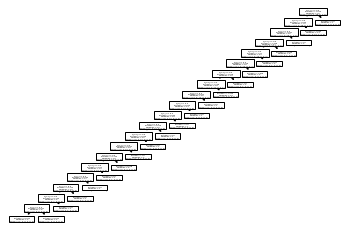

In [127]:
tree.plot_tree(clf)

# So after the analysis we have classified different areas based on Venues they have

## Basically we identified different clusters
### Cluster 5 is most suitable for families-      
### Pedralbes ,Sant Genís dels Agudells	,Torre Baró being the most suitable

### Cluster 2 is most suitable for Bachelors - 
### Fort Pienc,	Sants,Sants-Badal being the most suitable

### General good places for living are - El Congrés i els Indians,Can Peguera,Bon Pastor,Sant Andreu de Palomar,Vallvidrera,La Guineueta

### For Specific places with Indian Restaurants 
### Les Tres Torres	,Diagonal Mar i el Front Marítim del Poblenou




